# Yvonna Leung
# SJSU MS Project

In [ ]:
# Import libraries
import io
import os
import pandas as pd
from multiprocessing import Pool
import numpy as np
from matplotlib import pyplot as plt
from random import sample
import seaborn as sns

import sklearn as sk
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Data Preparation

In [219]:
import pipeline.notebook_lib as nb_lib

# Import SRA record from NCBI SRA database
srr_names = [
    'SRR14724463',
    'SRR14724473',
    'SRR14724493',
    'SRR14724503',
    'ERR1905890',
    'ERR1905889',
    'SRR2106344',
    'SRR2106342',
    'SRR1611184',
    'SRR1611183',
    'SRR1611182',
    'SRR1611181',
    'SRR1611180',
    'SRR1611179',
    'SRR1611178',
    'SRR504510',
]

In [226]:
import importlib
_ = importlib.reload(nb_lib)

In [227]:
# Read the GIAB VCF file into a DF file
giab_dfs = []
for srr_name in srr_names:
    giab_vcf_feather = f'pipeline/{srr_name}/GIAB_variants_intersect_bedfile.ftr' # changed from .ftr to .vcf
    giab_df = pd.read_feather(giab_vcf_feather).set_index(["CHROM", "POS"])
    giab_dfs.append(giab_df)

In [228]:
# Read the dataset VCF files into a list of dataframes
srr_dfs = []
for srr_name in srr_names:  
    srr_vcf_feather = f'pipeline/{srr_name}/{srr_name}_variants.ftr' # Custom for every notebook
    srr_df = pd.read_feather(srr_vcf_feather).set_index(["CHROM", "POS"])
    srr_dfs.append(srr_df)

In [229]:
# Only select SNVs from the GIAB datasets
giab_snv_dfs = []
for giab_df in giab_dfs:
    giab_snv_df = nb_lib.filter_for_snvs(giab_df)
    giab_snv_dfs.append(giab_snv_df)

# Only select SNVs from the SRR datasets
srr_snv_dfs = []
for srr_name, srr_df in zip(srr_names, srr_dfs):
    srr_snv_df = nb_lib.filter_for_snvs(srr_df)
    srr_snv_dfs.append(srr_snv_df)


In [199]:
# Join each SRR SNV DF with GIAB DF
joined_dfs = []
for srr_snv_df, giab_snv_df in zip(srr_snv_dfs, giab_snv_dfs):
    joined_df = nb_lib.join_datasets(srr_snv_df, giab_snv_df)
    joined_dfs.append(joined_df)

In [200]:
# Count the number of artifacts per case

# Case 1: GIAB and SRR contain the same variant at the same locus -> Label as FALSE (not an artifact)
# Case 2: GIAB contains a variant and SRR contains a different variant at the same locus -> Label as TRUE (is an artifact)
# Case 3: GIAB contains a variant, but SRR does not contain a variant in the same locus -> Label as TRUE (is an artifact)
# Case 4: SRR contains a variant, but GIAB does not contain a variant in the same locus -> Label as TRUE (is an artifact)

artifact_cols = []
for srr_name, joined_df in zip(srr_names, joined_dfs):
    print(f"Stats for {srr_name}")
    artifact_col = nb_lib.extract_artifacts_column(joined_df)
    artifact_cols.append(artifact_col)
    print("")

Stats for SRR14724463
Case 1: 24259
Case 2: 2
Case 3: 1601
Case 4: 102031

Stats for SRR14724473
Case 1: 16129
Case 2: 0
Case 3: 1295
Case 4: 55813

Stats for SRR14724493
Case 1: 24121
Case 2: 1
Case 3: 1740
Case 4: 89054

Stats for SRR14724503
Case 1: 16093
Case 2: 1
Case 3: 1330
Case 4: 58612

Stats for ERR1905890
Case 1: 17035
Case 2: 2
Case 3: 1124
Case 4: 37654

Stats for ERR1905889
Case 1: 17087
Case 2: 0
Case 3: 1074
Case 4: 43938

Stats for SRR2106344
Case 1: 24236
Case 2: 0
Case 3: 1626
Case 4: 240189

Stats for SRR2106342
Case 1: 49106
Case 2: 1
Case 3: 2595
Case 4: 95916

Stats for SRR1611184
Case 1: 38522
Case 2: 0
Case 3: 3031
Case 4: 46890

Stats for SRR1611183
Case 1: 38834
Case 2: 1
Case 3: 2718
Case 4: 52682

Stats for SRR1611182
Case 1: 38789
Case 2: 1
Case 3: 2763
Case 4: 55423

Stats for SRR1611181
Case 1: 38794
Case 2: 1
Case 3: 2758
Case 4: 52300

Stats for SRR1611180
Case 1: 38347
Case 2: 3
Case 3: 3203
Case 4: 48597

Stats for SRR1611179
Case 1: 38831
Case 2: 1


In [201]:
# Extract features for training
dfs = []
for srr_snv_df, artifact_col in zip(srr_snv_dfs, artifact_cols):
    df = nb_lib.extract_features_for_training(srr_snv_df, artifact_col)
    dfs.append(df)

In [202]:
# Concatenate the dataframes
df = pd.concat(dfs)

## Data Exploration

In [204]:
# Investigate column types
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1599887 entries, ('chr1', 826751) to ('chrX', 143884378)
Data columns (total 38 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ALT          1599887 non-null  object 
 1   REF          1599887 non-null  object 
 2   BIAS         1599887 non-null  object 
 3   FORMAT       1599887 non-null  object 
 4   LongMSI      1599887 non-null  bool   
 5   MSI12        1599887 non-null  bool   
 6   NM5.25       1599887 non-null  bool   
 7   PASS         1599887 non-null  bool   
 8   Q10          1599887 non-null  bool   
 9   REFBIAS      1599887 non-null  object 
 10  SVTYPE       0 non-null        object 
 11  VARBIAS      1599887 non-null  object 
 12  p8           1599887 non-null  bool   
 13  pSTD         1599887 non-null  bool   
 14  ADJAF        1599887 non-null  float64
 15  AF           1599887 non-null  float64
 16  DP           1599887 non-null  int64  
 17  DUPRATE      159988

In [203]:
# Look at statistical data
df.describe()

,ADJAF,AF,DP,DUPRATE,HIAF,HICNT,HICOV,MQ,MSI,MSILEN,...,PSTD,QSTD,QUAL,SBF,SHIFT3,SN,SPANPAIR,SPLITREAD,SVLEN,VD
count,1.599887e+06,1.599887e+06,1.599887e+06,1599887.0,1.599887e+06,1.599887e+06,1.599887e+06,1.599887e+06,1.599887e+06,1.599887e+06,...,1.599887e+06,1.599887e+06,1.599887e+06,1.599887e+06,1.599887e+06,1.599887e+06,1.599887e+06,1.599887e+06,0.0,1.599887e+06
mean,1.085244e-02,2.199130e-01,1.075462e+02,0.0,2.211869e-01,2.006655e+01,1.029691e+02,5.863585e+01,1.873366e+00,1.149776e+00,...,9.355529e-01,7.458814e-01,3.569112e+01,8.202407e-01,3.610524e-01,1.506790e+01,1.625115e-04,1.937637e-04,NaN,2.082722e+01
std,2.343098e-02,3.286469e-01,7.599535e+01,0.0,3.297470e-01,4.938796e+01,7.330401e+01,8.551737e+00,1.046685e+00,4.865156e-01,...,2.455477e-01,4.353647e-01,3.685365e+00,2.776912e-01,7.249472e-01,2.798106e+01,6.465502e-02,4.210212e-02,NaN,5.089267e+01
min,0.000000e+00,1.000000e-02,2.000000e+00,0.0,6.200000e-03,2.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,2.250000e+01,0.000000e+00,0.000000e+00,1.500000e+00,0.000000e+00,0.000000e+00,NaN,2.000000e+00
25%,0.000000e+00,1.670000e-02,5.900000e+01,0.0,1.690000e-02,2.000000e+00,5.600000e+01,6.000000e+01,1.000000e+00,1.000000e+00,...,1.000000e+00,0.000000e+00,3.400000e+01,5.642200e-01,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,NaN,2.000000e+00
50%,0.000000e+00,2.860000e-02,9.100000e+01,0.0,2.940000e-02,2.000000e+00,8.700000e+01,6.000000e+01,2.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,3.650000e+01,1.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,NaN,2.000000e+00
75%,1.160000e-02,4.366000e-01,1.400000e+02,0.0,4.375000e-01,1.800000e+01,1.340000e+02,6.000000e+01,2.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,3.800000e+01,1.000000e+00,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,NaN,1.900000e+01
max,7.500000e-01,1.000000e+00,2.399000e+03,0.0,1.000000e+00,1.628000e+03,2.258000e+03,6.000000e+01,2.600000e+01,6.000000e+00,...,1.000000e+00,1.000000e+00,4.100000e+01,1.000000e+00,6.900000e+01,9.980000e+02,3.500000e+01,3.200000e+01,NaN,1.723000e+03


ADJAF


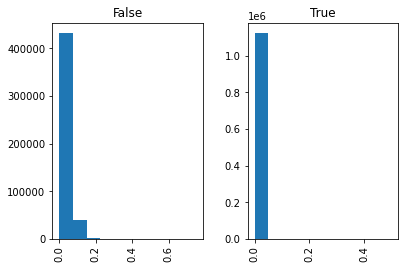

AF


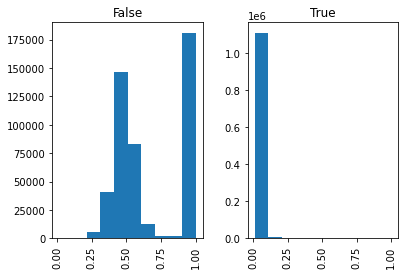

DP


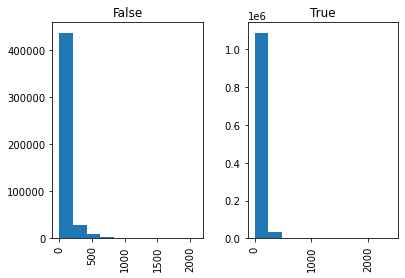

DUPRATE


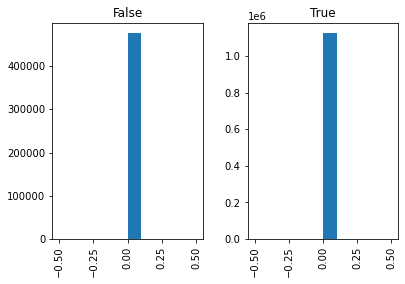

HIAF


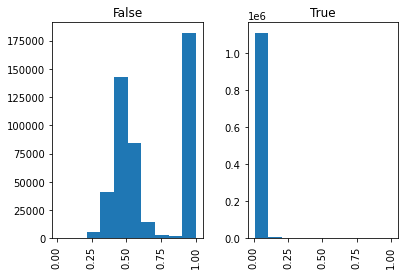

HICNT


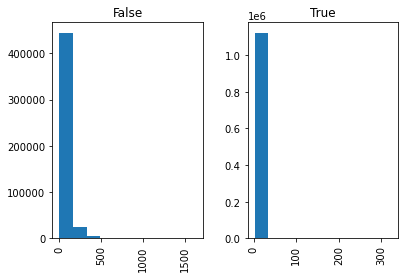

HICOV


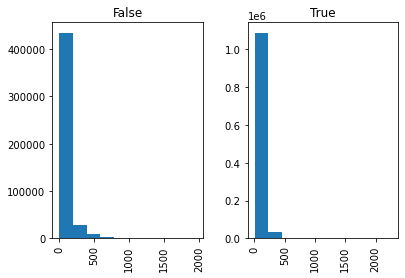

MQ


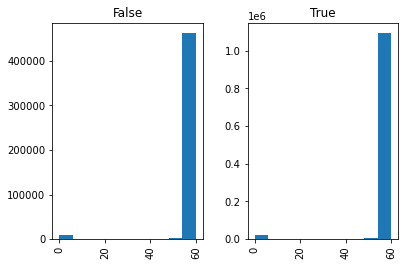

MSI


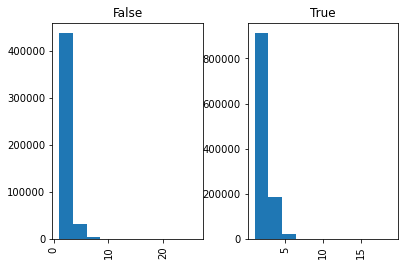

MSILEN


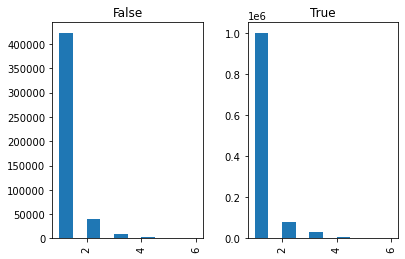

NM


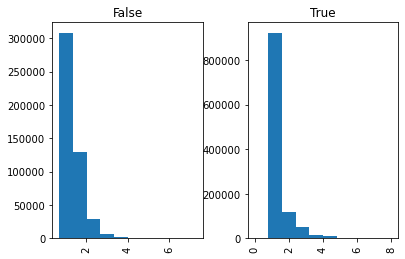

ODDRATIO


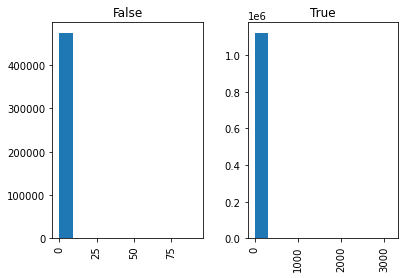

PMEAN


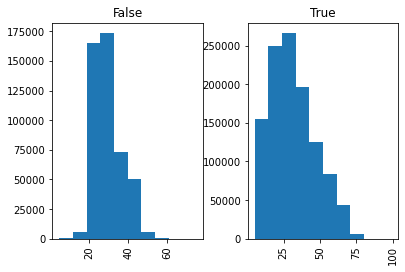

PSTD


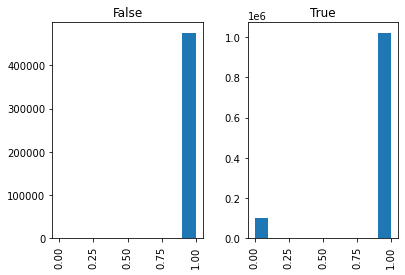

QSTD


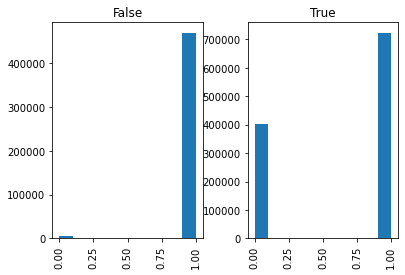

QUAL


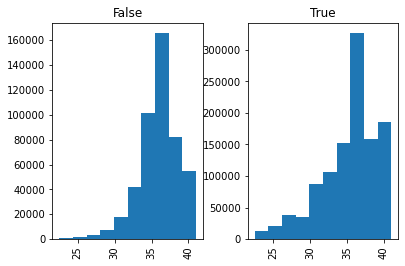

SBF


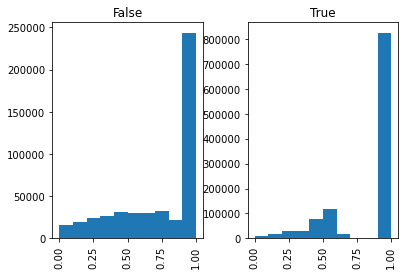

SHIFT3


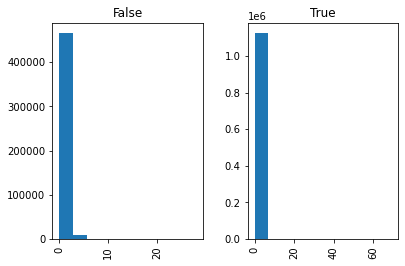

SN


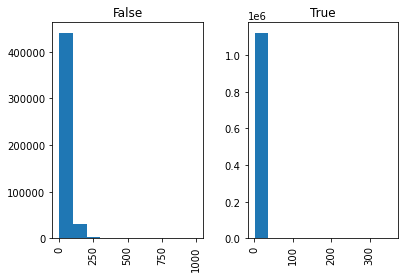

SPANPAIR


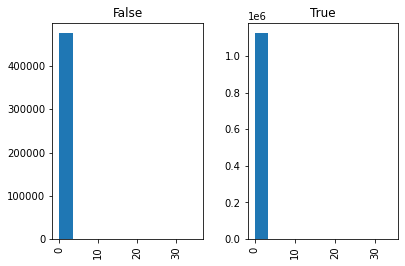

SPLITREAD


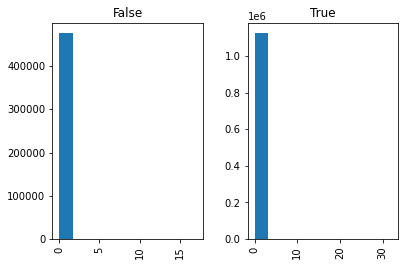

SVLEN


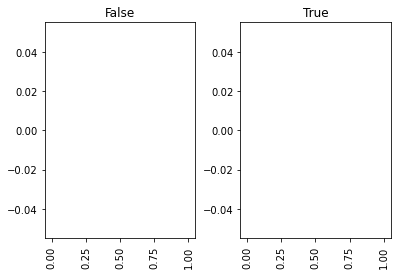

VD


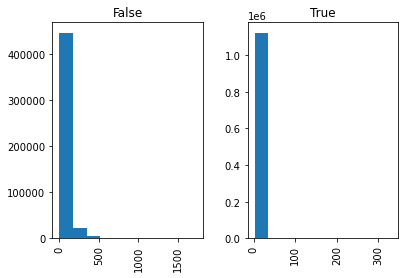

In [209]:
# Visualize the graphs of each column.
# This cell only visualizes numerical features since it is not possible to visualize categorical features

for col in nb_lib.numerical_features:
    print(col)
    try:
        df.hist(column=col, by="IS_ARTIFACT")
        plt.show()
    except:
        print("failed!")



Artifact Investigation

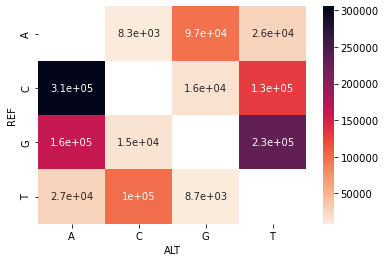

In [213]:
# Investigate sequencing artifacts frequency
artifacts_only = df_sample[df_sample['IS_ARTIFACT']]
df_pivoted = (
    artifacts_only[["REF", "ALT"]]
    .value_counts()
    .to_frame()
    .reset_index()
    .pivot("REF", "ALT", 0)
)
sns.heatmap(
    df_pivoted,
    annot=True,
    fmt=".2g",
    cmap="rocket_r"
)
plt.show()

In [214]:
df_pivoted

ALT,A,C,G,T
REF,,,,
A,NaN,8267.0,97107.0,26500.0
C,305633.0,NaN,16117.0,129526.0
G,159743.0,15147.0,NaN,230887.0
T,26824.0,99696.0,8689.0,NaN


C>A and G>T base substitutions are the most prevalent, ranging from approximately 230,000 to 310,000 substitutions.

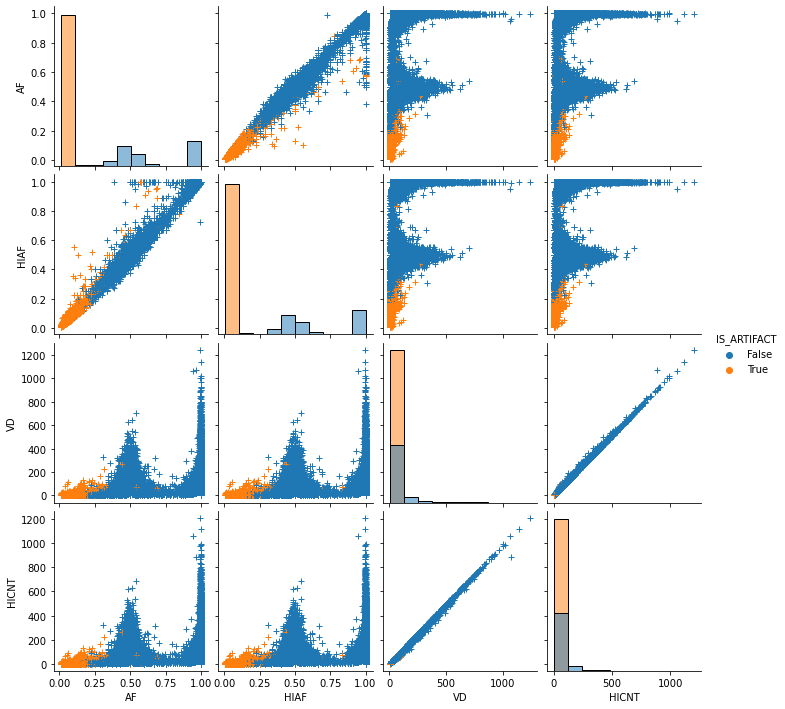

In [177]:
# Basic correlogram
pairplot_df = (
    df_sample
    .sample(frac=0.1)
    [['AF', 'HIAF', 'VD', 'HICNT', 'IS_ARTIFACT']]
)
sns.pairplot(
    pairplot_df,
    hue='IS_ARTIFACT',
    diag_kind="hist",
    kind='scatter',
    plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(bins=10)
)
plt.show()

It can be explained that `AF`, `HIAF`, `VD`, and `HICNT` have comparable model performance metrics because the features themselves could be similar in nature. Since they are similar, eliminating only one of them will not greatly affect the performance of the model. For instance, `AF` and `HIAF` represent allele frequency and `AF` using only high quality bases'. It can be deduced that these 2 features contain similar data and perhaps `HIAF` contains a more filtered version of `AF`. `VD` and `HICNT` represent `variant depth` and `number of high-quality reads with the variant`. Since both are related to read coverage and depth, it can also be deduced that these 2 features contain similar data as well. 

## Data Pre-processing

In [175]:
# Preprocess the dataframe into X and y arrays suitable for sklearn
X, y = nb_lib.preprocess_dataframe(df)

In [176]:
df_sample = df.sample(frac=1.0).reset_index()
df_sample.IS_ARTIFACT.value_counts()

True     1124136
False     475751
Name: IS_ARTIFACT, dtype: int64

In [178]:
X_sample, y_sample = nb_lib.preprocess_dataframe(df_sample)

## Performance Evaluation of Machine Learning Models

Decision Tree

3-fold Cross-Validation...
Scores: [0.99704667 0.99727731 0.99730918]
Mean: 0.9972110530919549
Standard deviation: 0.00011696363285964148
Validating using train/test split


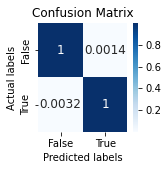

Precision: 0.9993973025942775
Recall: 0.9967806715617082


In [182]:
from sklearn import tree

dt_cls = tree.DecisionTreeClassifier(max_depth=1, class_weight='balanced')
nb_lib.train_and_evaluate_model(dt_cls, X_sample, y_sample)

Random Forest Model

3-fold Cross-Validation...
Scores: [0.98878296 0.98909236 0.98232873]
Mean: 0.9867346853834329
Standard deviation: 0.003118040465144766
Validating using train/test split


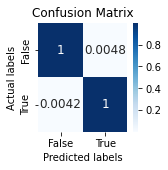

Precision: 0.997947326616034
Recall: 0.9958010695472903


In [179]:
# Train and evaluate the Random Forest model
rf_cls = nb_lib.build_rf_classifier()
nb_lib.train_and_evaluate_model(rf_cls, X_sample, y_sample)

Logistic Regression Model

3-fold Cross-Validation...
Scores: [0.99839114 0.99828613 0.99837613]
Mean: 0.9983511335644328
Standard deviation: 4.637079124544967e-05
Validating using train/test split


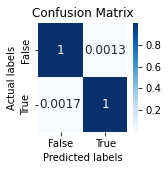

Precision: 0.9994338874104584
Recall: 0.998348034784777


In [180]:
# Train and evaluate the Logistic Regression model
lr_cls = nb_lib.build_lr_classifier()
nb_lib.train_and_evaluate_model(lr_cls, X_sample, y_sample)

SGD Classifier Model

3-fold Cross-Validation...
Scores: [0.99827113 0.998183   0.9982505 ]
Mean: 0.9982348753478364
Standard deviation: 3.763735372431316e-05
Validating using train/test split


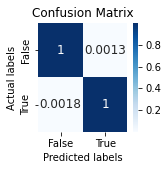

Precision: 0.9994426907780929
Recall: 0.9981565671183226


In [181]:
# Train and evaluate the SGD Classifier model
sgd_cls = nb_lib.build_sgd_classifier()
nb_lib.train_and_evaluate_model(sgd_cls, X_sample, y_sample)

ROC Curve and AUC Scores

/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the cla

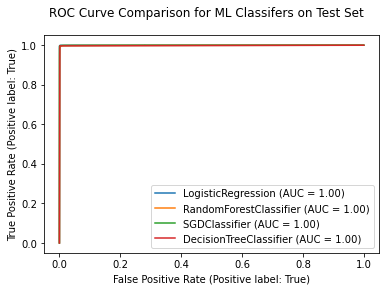

In [184]:
# Plot the test data using ROC curve and calculate AUC Scores

# Create a ROC Curve
from sklearn import metrics
from sklearn.metrics import plot_roc_curve

LRplot = plot_roc_curve(lr_cls, X_sample, y_sample)
RFplot = plot_roc_curve(rf_cls, X_sample, y_sample, ax=LRplot.ax_)
SGDplot = plot_roc_curve(sgd_cls, X_sample, y_sample, ax=LRplot.ax_)
DTplot = plot_roc_curve(dt_cls, X_sample, y_sample, ax=LRplot.ax_)

LRplot.figure_.suptitle('ROC Curve Comparison for ML Classifers on Test Set')

plt.show()

Precision-Recall Curve

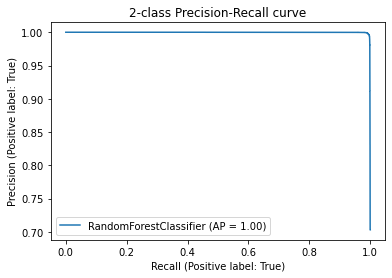

In [210]:
# Precision-Recall Curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.33, random_state=42)
rf_cls = nb_lib.build_rf_classifier()
rf_cls.fit(X_train, y_train)


display = PrecisionRecallDisplay.from_estimator(
    rf_cls, X_test, y_test
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Investigate Feature Predictive Power

Feature Removal

In [ ]:
# Investigate predictive power of features
# Randomly selects features  
from collections import defaultdict
features_and_scores = []

for i in range(1000):
    try:
        cls = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=0,
        n_jobs=16,
        class_weight='balanced'
    )

        features_to_keep = nb_lib.select_random_features(3)
        X, y = nb_lib.preprocess_with_features(df_sample, features_to_keep)
        score = nb_lib.evaluate_feature_removal_model(cls, X, y)

        key = tuple(sorted(features_to_keep))
        features_and_scores.append((key, score))
        print(i, key, score)
    except Exception as e:
        print(e)

0 ('DP', 'DUPRATE', 'VD') 0.9967303940790009
1 ('MQ', 'MSI', 'REFBIAS') 0.8021054207635561
2 ('MSI', 'MSI12', 'Q10') 0.5165308545236116
3 ('ALT', 'DUPRATE', 'HIAF') 0.9970272900375118
4 ('LongMSI', 'QUAL', 'SVTYPE') 0.641074650562126
5 ('QSTD', 'REF', 'SVTYPE') 0.5441971834096697
6 ('DP', 'PASS', 'SN') 0.9787835016605748
7 ('AF', 'DP', 'PMEAN') 0.9973073098100018
8 ('BIAS', 'VD', 'pSTD') 0.9908206017405402
9 ('LongMSI', 'QUAL', 'SPANPAIR') 0.5103629193178992
10 ('ALT', 'SN', 'VARBIAS') 0.9625423473914169
11 ('ALT', 'PMEAN', 'SN') 0.9667489013758804
12 ('HICNT', 'SN', 'SVTYPE') 0.9875416202417718
13 ('MSILEN', 'SHIFT3', 'pSTD') 0.3764615875104525
14 ('MSI', 'SPANPAIR', 'VARBIAS') 0.8985778662669318
15 ('ADJAF', 'SHIFT3', 'SVLEN') 0.8824048196996643
16 ('REF', 'SVLEN', 'VD') 0.9875141183517983
17 ('BIAS', 'MSILEN', 'QSTD') 0.6216432778717803
18 ('MSI12', 'QSTD', 'REF') 0.5441971834096697
19 ('AF', 'MSILEN', 'PMEAN') 0.9972341796393237
20 ('DP', 'PMEAN', 'Q10') 0.740360414621386
21 ('PSTD

In [225]:
# Calculates accuracy score of each feature
all_features = numerical_features + categorical_features

output = []
for feature in all_features:
    
    total_score = 0
    num_scores = 0
    for features, score in features_and_scores:
        if feature in features:
            total_score += score
            num_scores += 1
            
    if num_scores > 1:
        avg_score = total_score / num_scores
        output.append((avg_score, feature, num_scores))
        
output.sort(reverse = True)
for score, feature, num_scores in output:
    print("{:.3f}:\t{:10}{} models".format(score, feature, num_scores))

print()
feature_order = [feature for (score, feature, _) in output]
print(feature_order)
print()

0.995:	AF        86 models
0.992:	HIAF      80 models
0.985:	HICNT     90 models
0.985:	VD        76 models
0.973:	SN        89 models
0.921:	ADJAF     86 models
0.908:	VARBIAS   99 models
0.882:	NM        93 models
0.863:	BIAS      62 models
0.852:	REFBIAS   70 models
0.834:	SBF       68 models
0.825:	ODDRATIO  100 models
0.819:	REF       81 models
0.810:	ALT       86 models
0.804:	DP        78 models
0.797:	HICOV     76 models
0.787:	MQ        77 models
0.787:	PMEAN     85 models
0.784:	LongMSI   72 models
0.772:	MSI       86 models
0.771:	FORMAT    71 models
0.770:	PASS      62 models
0.767:	DUPRATE   78 models
0.764:	SVLEN     59 models
0.760:	MSI12     77 models
0.760:	SVTYPE    92 models
0.752:	SPLITREAD 98 models
0.752:	pSTD      79 models
0.750:	QUAL      93 models
0.749:	QSTD      81 models
0.742:	Q10       86 models
0.738:	MSILEN    69 models
0.734:	p8        66 models
0.726:	NM5.25    82 models
0.724:	SHIFT3    81 models
0.721:	SPANPAIR  75 models
0.719:	PSTD      75 models



3-fold Cross-Validation...
Scores: [0.99512466 0.98444204 0.99686852]
Mean: 0.992145073197952
Standard deviation: 0.005493199101257378
Precision: 0.9988028606270688
Recall: 0.9956274128265525


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


All Features & 99.2\%   & 99.9\%    & 99.6\% \\


3-fold Cross-Validation...
Scores: [0.98644468 0.99274137 0.98107614]
Mean: 0.9867540609568545
Standard deviation: 0.00476733117167721
Precision: 0.9943329821336502
Recall: 0.9875323379983169


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `AF' & 98.7\%   & 99.4\%    & 98.8\% \\


3-fold Cross-Validation...
Scores: [0.98033362 0.97682338 0.97165359]
Mean: 0.9762701961972261
Standard deviation: 0.0035651332319774657
Precision: 0.994921791108884
Recall: 0.9901505470186703


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `HIAF' & 97.6\%   & 99.5\%    & 99.0\% \\


3-fold Cross-Validation...
Scores: [0.91437213 0.983902   0.98277314]
Mean: 0.9603490886694174
Standard deviation: 0.032513884787688255
Precision: 0.9898536726274836
Recall: 0.9765296262818315


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `HICNT' & 96.0\%   & 99.0\%    & 97.7\% \\


3-fold Cross-Validation...
Scores: [0.96093352 0.91617038 0.96009901]
Mean: 0.9457343014629819
Standard deviation: 0.020907623884693735
Precision: 0.9880530830081605
Recall: 0.9504722126983137


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `VD' & 94.6\%   & 98.8\%    & 95.0\% \\


3-fold Cross-Validation...
Scores: [0.95533625 0.92375716 0.93218763]
Mean: 0.9370936791748085
Standard deviation: 0.01335069734117988
Precision: 0.9679076588714451
Recall: 0.9756524372052845


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `SN' & 93.7\%   & 96.8\%    & 97.6\% \\


3-fold Cross-Validation...
Scores: [0.93865696 0.85542175 0.9088797 ]
Mean: 0.9009861370794084
Standard deviation: 0.034435988452044465
Precision: 0.9974575050082968
Recall: 0.9555394267547122


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `ADJAF' & 90.1\%   & 99.7\%    & 95.6\% \\


3-fold Cross-Validation...
Scores: [0.82093434 0.81057424 0.7649256 ]
Mean: 0.7988113948761438
Standard deviation: 0.02433129719981594
Precision: 0.9166729860779652
Recall: 0.9150239779856711


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `VARBIAS' & 79.9\%   & 91.7\%    & 91.5\% \\


3-fold Cross-Validation...
Scores: [0.8157121  0.8164734  0.82721008]
Mean: 0.8197985279032537
Standard deviation: 0.005249967116879953
Precision: 0.939957653620386
Recall: 0.7294161126720426


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `NM' & 82.0\%   & 94.0\%    & 72.9\% \\


3-fold Cross-Validation...
Scores: [0.77251845 0.82271572 0.78304316]
Mean: 0.7927591075395005
Standard deviation: 0.021613901481785415
Precision: 0.9141894580470594
Recall: 0.767255466847151


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `BIAS' & 79.3\%   & 91.4\%    & 76.7\% \\


3-fold Cross-Validation...
Scores: [0.84041133 0.84514604 0.83812899]
Mean: 0.8412287848455583
Standard deviation: 0.002922431052313686
Precision: 0.9837589711424781
Recall: 0.7891807410243965


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `REFBIAS' & 84.1\%   & 98.4\%    & 78.9\% \\


3-fold Cross-Validation...
Scores: [0.81250938 0.80816657 0.8180463 ]
Mean: 0.8129074147979716
Standard deviation: 0.004043189331081308
Precision: 0.9813357467799069
Recall: 0.7290420828119921


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `SBF' & 81.3\%   & 98.1\%    & 72.9\% \\


3-fold Cross-Validation...
Scores: [0.80939853 0.81268376 0.81574176]
Mean: 0.8126080173998158
Standard deviation: 0.002590163991669743
Precision: 0.976981129879727
Recall: 0.7476278046673583


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `ODDRATIO' & 81.3\%   & 97.7\%    & 74.8\% \\


3-fold Cross-Validation...
Scores: [0.78983529 0.78854707 0.79004116]
Mean: 0.7894745069912138
Standard deviation: 0.0006611583953824372
Precision: 0.9808226554564257
Recall: 0.7137202167592094


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `REF' & 78.9\%   & 98.1\%    & 71.4\% \\


3-fold Cross-Validation...
Scores: [0.77675437 0.7742642  0.77400501]
Mean: 0.7750078593032802
Standard deviation: 0.0012394964487854715
Precision: 0.9805634527642322
Recall: 0.6957044451667772


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `ALT' & 77.5\%   & 98.1\%    & 69.6\% \\


3-fold Cross-Validation...
Scores: [0.73264191 0.73025862 0.73010623]
Mean: 0.7310022514739947
Standard deviation: 0.0011610815955532018
Precision: 0.9813473228412024
Recall: 0.6297059858135817


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `DP' & 73.1\%   & 98.1\%    & 63.0\% \\


3-fold Cross-Validation...
Scores: [0.71085288 0.72334688 0.70984727]
Mean: 0.7146823464187931
Standard deviation: 0.0061404927804994385
Precision: 0.9750801021920477
Recall: 0.6152034232637668


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `HICOV' & 71.5\%   & 97.5\%    & 61.5\% \\


3-fold Cross-Validation...
Scores: [0.71148668 0.71059787 0.70987352]
Mean: 0.7106526893592063
Standard deviation: 0.0006597084877137516
Precision: 0.9747299438283162
Recall: 0.6026823284249335


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `MQ' & 71.1\%   & 97.5\%    & 60.3\% \\


3-fold Cross-Validation...
Scores: [0.60342474 0.60240467 0.60151698]
Mean: 0.6024487973639304
Standard deviation: 0.0007794628407995013
Precision: 0.9856670013020963
Recall: 0.4415556079988957


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `PMEAN' & 60.2\%   & 98.6\%    & 44.2\% \\


3-fold Cross-Validation...
Scores: [0.60415604 0.60292595 0.60162387]
Mean: 0.6029019541517073
Standard deviation: 0.0010338950875715062
Precision: 0.9751752393157415
Recall: 0.4472551106282366


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `LongMSI' & 60.3\%   & 97.5\%    & 44.7\% \\


3-fold Cross-Validation...
Scores: [0.6060518  0.66674042 0.6049091 ]
Mean: 0.6259004410990663
Standard deviation: 0.028881995059923195
Precision: 0.9847542706706353
Recall: 0.4463734688152604


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `MSI' & 62.6\%   & 98.5\%    & 44.6\% \\


3-fold Cross-Validation...
Scores: [0.60596554 0.60553426 0.60541351]
Mean: 0.6056377730275583
Standard deviation: 0.00023695245889754636
Precision: 0.9756153735425364
Recall: 0.45268299633539794


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `FORMAT' & 60.6\%   & 97.6\%    & 45.3\% \\


3-fold Cross-Validation...
Scores: [0.70046653 0.60322223 0.67767746]
Mean: 0.6604554054267912
Standard deviation: 0.041525599644692095
Precision: 0.9867718036824439
Recall: 0.4424327970754427


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `PASS' & 66.0\%   & 98.7\%    & 44.2\% \\


3-fold Cross-Validation...
Scores: [0.60662559 0.6995871  0.60430343]
Mean: 0.6368387063990945
Standard deviation: 0.04437993846768962
Precision: 0.9444859813084112
Recall: 0.6074912837684399


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `DUPRATE' & 63.7\%   & 94.4\%    & 60.7\% \\


3-fold Cross-Validation...
Scores: [0.60662559 0.6995871  0.60430343]
Mean: 0.6368387063990945
Standard deviation: 0.04437993846768962
Precision: 0.9444859813084112
Recall: 0.6074912837684399


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `SVLEN' & 63.7\%   & 94.4\%    & 60.7\% \\


3-fold Cross-Validation...
Scores: [0.70052466 0.69918957 0.67726493]
Mean: 0.6923263861376099
Standard deviation: 0.010663997066229168
Precision: 0.9681236013902775
Recall: 0.54323829709548


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `MSI12' & 69.2\%   & 96.8\%    & 54.3\% \\


3-fold Cross-Validation...
Scores: [0.60417104 0.61976276 0.66564847]
Mean: 0.6298607562832327
Standard deviation: 0.026094005232846267
Precision: 0.9830244976390726
Recall: 0.4533019266990529


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `SVTYPE' & 63.0\%   & 98.3\%    & 45.3\% \\


3-fold Cross-Validation...
Scores: [0.60590366 0.6995871  0.69883273]
Mean: 0.6681078293185078
Standard deviation: 0.043986065779882524
Precision: 0.9437225551658427
Recall: 0.6086222788214497


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `SPLITREAD' & 66.8\%   & 94.4\%    & 60.9\% \\


3-fold Cross-Validation...
Scores: [0.66664104 0.6057499  0.60480785]
Mean: 0.6257329293099552
Standard deviation: 0.028928958964797493
Precision: 0.9853702297978055
Recall: 0.44506436430508367


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `pSTD' & 62.6\%   & 98.5\%    & 44.5\% \\


3-fold Cross-Validation...
Scores: [0.59781997 0.59675302 0.59610535]
Mean: 0.596892780060445
Standard deviation: 0.0007069350769440281
Precision: 0.9874545047884346
Recall: 0.4324853838926712


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `QUAL' & 59.7\%   & 98.7\%    & 43.2\% \\


3-fold Cross-Validation...
Scores: [0.40307634 0.40321322 0.40294584]
Mean: 0.4030784673338614
Standard deviation: 0.00010917113355177423
Precision: 0.9085272063064795
Recall: 0.16832234249558065


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `QSTD' & 40.3\%   & 90.9\%    & 16.8\% \\


3-fold Cross-Validation...
Scores: [0.39674402 0.39681153 0.39669226]
Mean: 0.39674927038159064
Standard deviation: 4.8830774061111776e-05
Precision: 0.9330351091229497
Recall: 0.15324092420997323


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `Q10' & 39.7\%   & 93.3\%    & 15.3\% \\


3-fold Cross-Validation...
Scores: [0.38259428 0.3825624  0.3829269 ]
Mean: 0.38269452794626746
Standard deviation: 0.00016482490878824704
Precision: 0.9965218651498134
Recall: 0.12247251548439093


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `MSILEN' & 38.3\%   & 99.7\%    & 12.2\% \\


3-fold Cross-Validation...
Scores: [0.36462865 0.36443926 0.36489935]
Mean: 0.36465575396487265
Standard deviation: 0.00018880683519575212
Precision: 0.996741475056221
Recall: 0.09670452976876939


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `p8' & 36.5\%   & 99.7\%    & 9.7\% \\


3-fold Cross-Validation...
Scores: [0.36173345 0.3614653  0.36186351]
Mean: 0.36168741928404297
Standard deviation: 0.0001657929340661826
Precision: 0.9987001733102253
Recall: 0.09237201722318451


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `NM5.25' & 36.2\%   & 99.9\%    & 9.2\% \\


3-fold Cross-Validation...
Scores: [0.36172782 0.36145968 0.36186538]
Mean: 0.3616842940664497
Standard deviation: 0.0001684645632617036
Precision: 0.9987002358831175
Recall: 0.09237646995961368


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `SHIFT3' & 36.2\%   & 99.9\%    & 9.2\% \\


3-fold Cross-Validation...
Scores: [0.36172782 0.36145593 0.36185976]
Mean: 0.3616811688441683
Standard deviation: 0.00016813156693055534
Precision: 0.9987963408762638
Recall: 0.09237201722318451


/home/yleung/.conda/envs/jupyter-notebook/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Previous Row Minus `SPANPAIR' & 36.2\%   & 99.9\%    & 9.2\% \\

All Features & 99.2\%   & 99.9\%    & 99.6\% \\
Previous Row Minus `AF' & 98.7\%   & 99.4\%    & 98.8\% \\
Previous Row Minus `HIAF' & 97.6\%   & 99.5\%    & 99.0\% \\
Previous Row Minus `HICNT' & 96.0\%   & 99.0\%    & 97.7\% \\
Previous Row Minus `VD' & 94.6\%   & 98.8\%    & 95.0\% \\
Previous Row Minus `SN' & 93.7\%   & 96.8\%    & 97.6\% \\
Previous Row Minus `ADJAF' & 90.1\%   & 99.7\%    & 95.6\% \\
Previous Row Minus `VARBIAS' & 79.9\%   & 91.7\%    & 91.5\% \\
Previous Row Minus `NM' & 82.0\%   & 94.0\%    & 72.9\% \\
Previous Row Minus `BIAS' & 79.3\%   & 91.4\%    & 76.7\% \\
Previous Row Minus `REFBIAS' & 84.1\%   & 98.4\%    & 78.9\% \\
Previous Row Minus `SBF' & 81.3\%   & 98.1\%    & 72.9\% \\
Previous Row Minus `ODDRATIO' & 81.3\%   & 97.7\%    & 74.8\% \\
Previous Row Minus `REF' & 78.9\%   & 98.1\%    & 71.4\% \\
Previous Row Minus `ALT' & 77.5\%   & 98.1\%    & 69.6\% \\
Previous Row Minus `DP' & 73.1\%

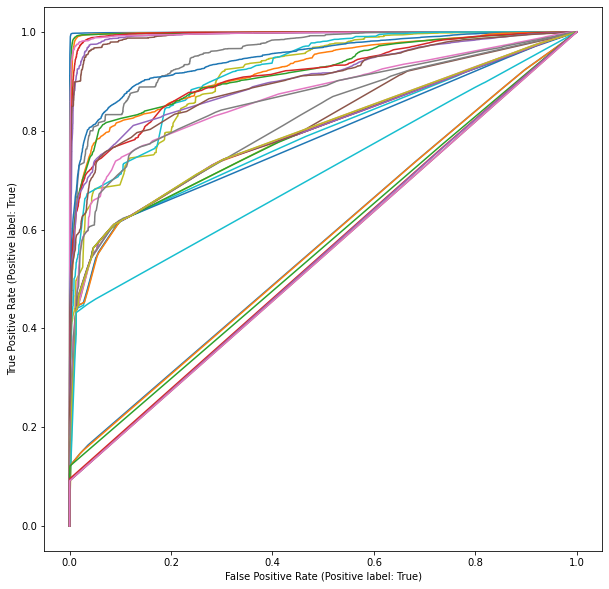

In [224]:
# Removes one feature sequentially and evaluates model accuracy

# Perform cross-validation
def evaluate_model(model, X, y):
  # Cross-validates, trains, and gets training accuracy for the given model.

  # Cross-validate (k-fold cross validation)
  print("3-fold Cross-Validation...")
  scores = cross_val_score(model, X, y, scoring="accuracy", cv=3)
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())
  
  # Train, test, and split the data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
  
  # Display confusion Matrix (Validation)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  labels = ['NON_ARTIFACT', 'IS_ARTIFACT']
  cm = confusion_matrix(y_test, y_pred)
  sum_of_rows = cm.sum(axis=1)
  normalized_cm = cm / sum_of_rows[:, np.newaxis]

  df_cm = pd.DataFrame(normalized_cm, index = ['False', 'True'],
                      columns = ['False', 'True'])

  true_positives = cm[1, 1]
  predicted_positives = cm[1,1] + cm[0, 1]
  actual_positives = cm[1,0] + cm[1, 1]
  precision =  true_positives / predicted_positives
  recall = true_positives / actual_positives
  print("Precision:", precision)
  print("Recall:", recall)
    
  latex = f" {scores.mean() * 100:.1f}\%   & {precision * 100:.1f}\%    & {recall * 100:.1f}\% \\\\"
    
  return latex

from collections import defaultdict
fig, ax = plt.subplots(figsize=(10, 10))

latex = []
for i in range(len(feature_order)):
#for i in range(5):
    try:
        cls = RandomForestClassifier(
            n_estimators=100,
            max_depth=4,
            random_state=0,
            n_jobs=16,
            class_weight='balanced'
        )

        print()
        features_to_keep = feature_order[i:]
        X, y = nb_lib.preprocess_with_features(df_sample, features_to_keep)
        ltx = evaluate_model(cls, X, y)
        plot_roc_curve(cls, X, y, ax=ax)

        s = ""
        if i == 0:
            s = "All Features "
        else:
            s = f"Previous Row Minus `{feature_order[i - 1]}' "
        ltx = s + "&" + ltx
        print(ltx)
        print()
        latex.append(ltx)
    except Exception as e:
        print(e)
    
print("\n".join(latex))
legend = ax.legend()
legend.remove()
plt.show()


## Determining Optimal Allele Frequency (AF) Threshold

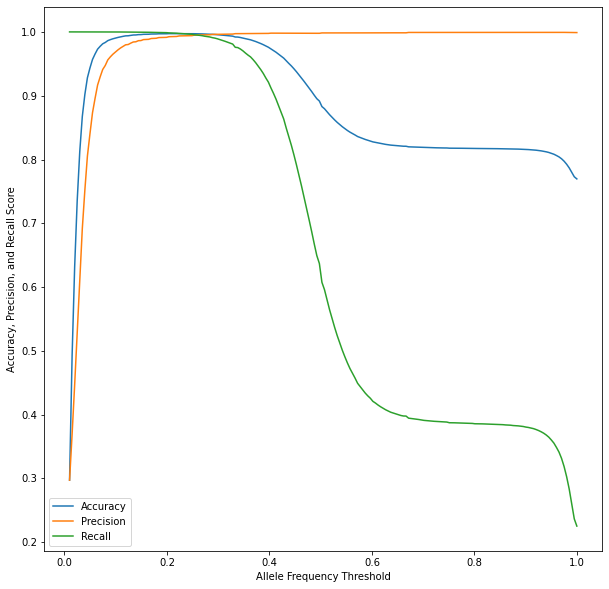

Best AF threshold: 0.22389798994974874


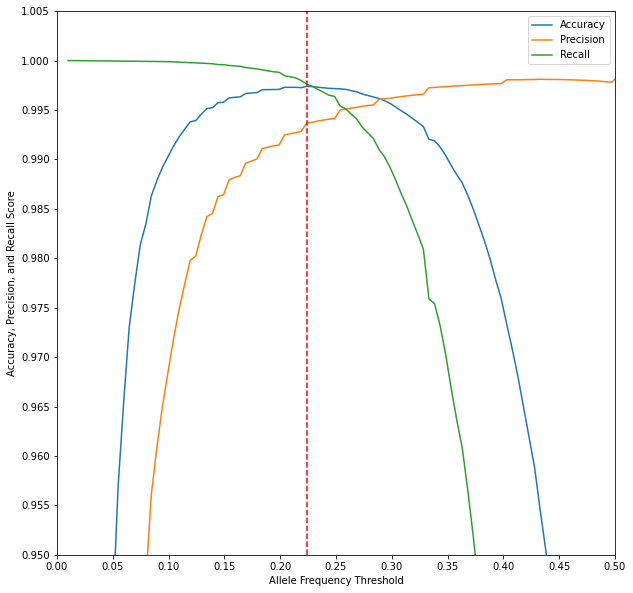

In [212]:

import matplotlib.ticker as ticker

af_acc = []
af_prec = []
af_rec = []
af_thresh = []

for aft in np.linspace(start = 0.01, stop = 0.9999, num = 200):
    af_thresh.append(aft)
    
    actual = ~df_sample.IS_ARTIFACT
    predicted = df_sample.AF >= aft
    
    true_pos = (actual & predicted).sum()
    true_neg = (~actual & ~predicted).sum()
    false_pos = (~actual & predicted).sum()
    false_neg = (actual & ~predicted).sum()
    
    acc = (true_pos + true_neg) / len(actual)
    prec = true_pos / predicted.sum()
    rec = true_pos / actual.sum()
    
    af_acc.append(acc)
    af_prec.append(prec)
    af_rec.append(rec)
    
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(af_thresh, af_acc)
plt.plot(af_thresh, af_prec)
plt.plot(af_thresh, af_rec)
_ = plt.legend(["Accuracy", "Precision", "Recall"])
ax.set_xlabel('Allele Frequency Threshold')
ax.set_ylabel('Accuracy, Precision, and Recall Score')
plt.show()

max_acc = max(af_acc)
max_acc_idx = af_acc.index(max_acc)
best_af_thresh = af_thresh[max_acc_idx]
print(f"Best AF threshold: {best_af_thresh:}")

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(af_thresh, af_acc)
plt.plot(af_thresh, af_prec)
plt.plot(af_thresh, af_rec)
_ = plt.legend(["Accuracy", "Precision", "Recall"])
ax.set_ylim(0.95, 1.005)
ax.set_xlim(0.000, 0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.axvline(x=best_af_thresh, linestyle='--', color='red')
ax.set_xlabel('Allele Frequency Threshold')
ax.set_ylabel('Accuracy, Precision, and Recall Score')

plt.show()